In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# The Data
The [bike sharing datset](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset) from the UCI ML repository contains information on the hourly count of rental bikes. The dataset contains features such as season, year, month, day, hour, weather etc. We need to predict the count of rental bikes from these features. The aim of this work is to compare the effectiveness of ensemble learning methods (bagging, boosting and stacking).

In [21]:
df = pd.read_csv('hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [22]:
df.shape

(17379, 17)

## One-Hot Encoding

The dataset contains 17379 entries and 13 columns (including the target). We remove a few columns which are not required for regression. One-hot encoding is performed on the categorical features.

In [23]:
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)
df_encoded = pd.get_dummies(df, columns=['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit'], drop_first=True)
df_encoded.head()

,temp,atemp,hum,windspeed,cnt,season_2,season_3,season_4,yr_1,mnth_2,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3,weathersit_4
0,0.24,0.2879,0.81,0.0,16,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.22,0.2727,0.80,0.0,40,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,0.22,0.2727,0.80,0.0,32,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,0.24,0.2879,0.75,0.0,13,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,0.24,0.2879,0.75,0.0,1,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [24]:
df_encoded.shape

(17379, 54)

## Splitting into train and split datasets

In [25]:
X = df.drop('cnt', axis=1).to_numpy()
y = df['cnt'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Single Model
We use a linear regression model and a decision tree regression model as the baseline models.

## Linear Regressor

In [26]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
print(f'Linear Regression RMSE: {rmse_linear:.2f}')

Linear Regression RMSE: 139.21


## Decision Tree Regressor

In [27]:
baseline_tree_model = DecisionTreeRegressor(max_depth=6, random_state=42)
baseline_tree_model.fit(X_train, y_train)
y_pred_tree = baseline_tree_model.predict(X_test)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print(f'Decision Tree RMSE: {rmse_tree:.2f}')

Decision Tree RMSE: 99.02


Decision tree model is chosen as the baseline as it gives a lower RMSE than the linear regressor.

# Bagging
In bagging, a number of models are trained over different subsets of the dataset. The prediction is given by the average of the individual predictions. This technique helps to reduce variance. Hence, it is useful when there is overfitting. We use a decision tree regressor with maximum depth of 6 (same as the previous section) as the baseline.

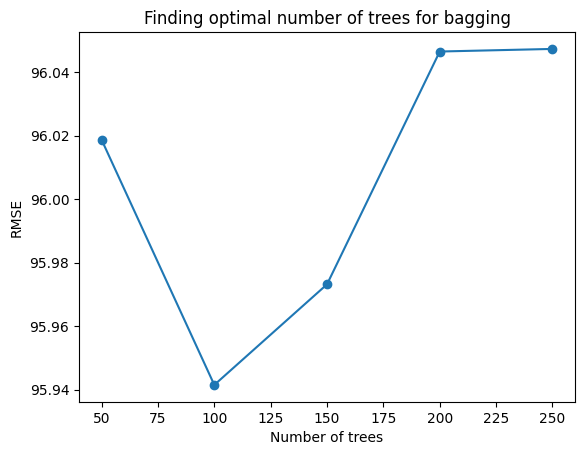

In [28]:
#Finding optimal number of decision trees for bagging
rmse_bagging_list = []
rmse_optimal_bagging = float('inf')
optimal_n_bagging = None
n_values = [50, 100, 150, 200, 250]

for n in n_values:
    bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6), n_estimators=n, random_state=42)
    bagging_model.fit(X_train, y_train)
    y_pred_bagging = bagging_model.predict(X_test)
    rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))
    rmse_bagging_list.append(rmse_bagging)
    if rmse_bagging < rmse_optimal_bagging:
        rmse_optimal_bagging = rmse_bagging
        optimal_n_bagging = n

plt.plot(n_values, rmse_bagging_list, marker='o')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.title('Finding optimal number of trees for bagging')
plt.show()

In [29]:
print(f'Optimal number of trees for bagging: {optimal_n_bagging} with RMSE: {rmse_optimal_bagging:.2f}')

Optimal number of trees for bagging: 100 with RMSE: 95.94


We observe that the reduction in RMSE with bagging is very less. This suggests that the baseline model is underfitting i.e., it has high bias and not much variance.

# Boosting
In this algorithm, the regressors are trained in succession with each model predicting the residue of the previous model. Thus, each model captures features that were not captured by the earlier models. This helps in reducing bias and is useful for dealing with underfitting.

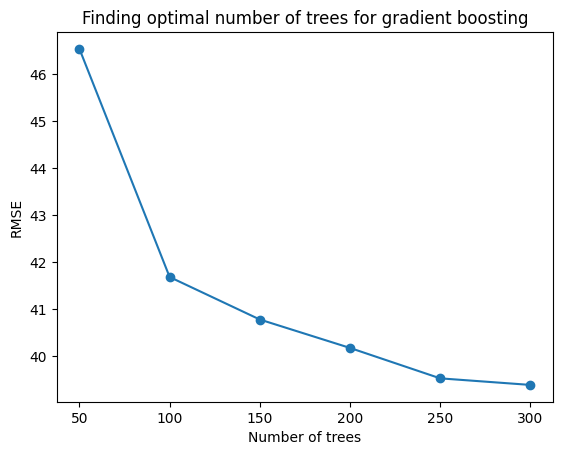

In [30]:
#Finding optimal number of estimators for gradient boosting
rmse_gb_list = []
rmse_optimal_gb = float('inf')
optimal_n_gb = None
n_values_gb = [50, 100, 150, 200, 250, 300]
for n in n_values_gb:
    gb_model = GradientBoostingRegressor(n_estimators=n,  max_depth=6, random_state=42)
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)
    rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
    rmse_gb_list.append(rmse_gb)
    if rmse_gb < rmse_optimal_gb:
        rmse_optimal_gb = rmse_gb
        optimal_n_gb = n

plt.plot(n_values_gb, rmse_gb_list, marker='o')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.title('Finding optimal number of trees for gradient boosting')
plt.show()

In [31]:
print(f'Optimal number of estimators for gradient boosting: {optimal_n_gb} with RMSE: {rmse_optimal_gb:.2f}')

Optimal number of estimators for gradient boosting: 300 with RMSE: 39.38


Boosting has significantly reduced RMSE compared to the baseline model. This implies that the baseline model has high bias.

# Stacking
A stacking classifier consists of base learners and a meta learner. the outputs of base learners are passed as inputs to the meta learner which makes the final prediction. Here, we use a KNN regressor, a bagging regressor and boosting regressor as the base learners and a ridge regressor as the meta-learner.

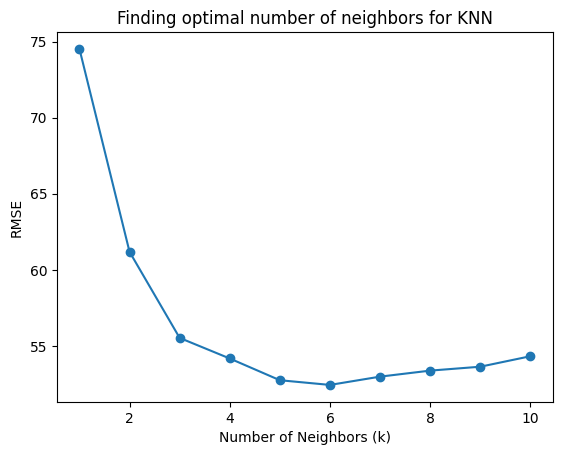

In [32]:
#Finding optimal number of neighbors for KNN
rmse_values = []
k_values = range(1, 11)
rmse_optimal = float('inf')
optimal_k = None
for k in k_values:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
    rmse_values.append(rmse_knn)
    if rmse_knn < rmse_optimal:
        rmse_optimal = rmse_knn
        optimal_k = k

plt.plot(k_values, rmse_values, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE')
plt.title('Finding optimal number of neighbors for KNN')
plt.show()

In [33]:
print(f'Optimal number of neighbors for KNN: {optimal_k} with RMSE: {rmse_optimal:.2f}')

Optimal number of neighbors for KNN: 6 with RMSE: 52.43


In [34]:
#Base learners
knn_model = KNeighborsRegressor(n_neighbors=6)
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6), n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=300, max_depth=6, random_state=42)
#Meta learner
ridge_meta = Ridge()

base_learners = [('knn', knn_model), ('bagging', bagging_model), ('boosting', gb_model)]
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=ridge_meta)
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
print(f'Stacking RMSE: {rmse_stacking:.2f}')

Stacking RMSE: 38.52


# Final Analysis
## Comparasion of models

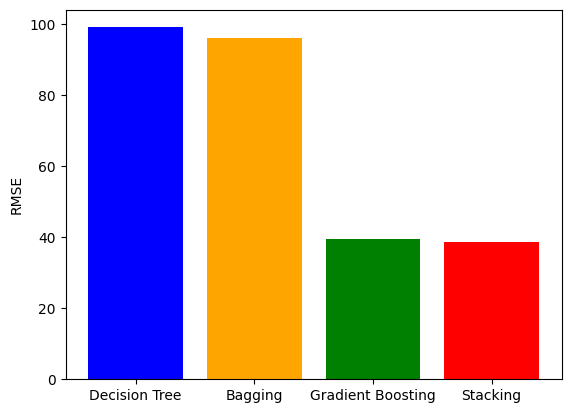

In [ ]:
#Bar graphs of RMSE values
models = ['Decision Tree', 'Bagging', 'Gradient Boosting', 'Stacking']
rmse_values = [rmse_tree, rmse_optimal_bagging, rmse_optimal_gb, rmse_stacking]
#bar with annotations
plt.bar(models, rmse_values, color=['blue', 'orange', 'green', 'red'])
plt.ylabel('RMSE')
plt.show()

## Conclusion
Stacking performs better than the baseline model and other ensemble models. This method reduces bias as well as variance. Using predictions of multiple models reduces overfitting, thus reducing variance. Model diversity allows it to capture more complex features, which reduces the bias.